In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd ./drive/MyDrive/

/content/drive/MyDrive


In [3]:
#!git clone https://github.com/eriklindernoren/PyTorch-YOLOv3.git

In [4]:
cd ./PyTorch-YOLOv3/

/content/drive/MyDrive/PyTorch-YOLOv3


In [5]:
#!bash ./weights/download_weights.sh 

In [6]:
!pip install -r requirements.txt

  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=6593877f7010ef652527b19168ef16a02bcb63265caaeaae04639a9f1f5e1394
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built terminaltables


In [7]:
!pip uninstall --yes imgaug && pip install git+https://github.com/aleju/imgaug.git

Uninstalling imgaug-0.2.9:
  Successfully uninstalled imgaug-0.2.9
  Cloning https://github.com/aleju/imgaug.git to /tmp/pip-req-build-w45v0fqg
  Running command git clone -q https://github.com/aleju/imgaug.git /tmp/pip-req-build-w45v0fqg
  Created wheel for imgaug: filename=imgaug-0.4.0-cp36-none-any.whl size=971106 sha256=17de308ac1cfd2ffa04a5bf1e2c0d09cacccd0b295db4b82049725a15be3d598
  Stored in directory: /tmp/pip-ephem-wheel-cache-h17q7o54/wheels/65/3d/94/ee32cbeaa29c473a4db74c2d21904ac747311fdca4732665f0
Successfully built imgaug
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.


In [8]:
from __future__ import division

from models import *
from utils.utils import *
from utils.datasets import *
from utils.augmentations import *
from utils.transforms import *

import os
import sys
import time
import datetime
import argparse
import pandas as pd

from PIL import Image

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator


Performing object detection:
	+ Batch 0, Inference Time: 0:00:00.958449

Saving images:
(0) Image: 'data/samples/task2.jpg'
	+ Label: person, Conf: 0.99864
	+ Label: person, Conf: 0.99795
	+ Label: person, Conf: 0.99448
	+ Label: person, Conf: 0.99501
	+ Label: person, Conf: 0.99872
	+ Label: person, Conf: 0.99753
Total Count: 6


<Figure size 432x288 with 0 Axes>

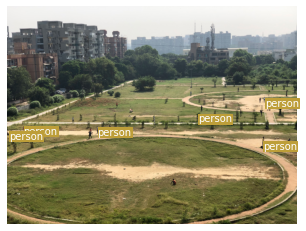

In [9]:

opt = {"image_folder": "data/samples",
"model_def": "config/yolov3.cfg",
"weights_path": "weights/yolov3.weights",
"class_path": "data/coco.names",
"conf_thres": 0.8,
"nms_thres": 0.4,
"batch_size": 1,
"n_cpu": 0,
"img_size": 416}

opt = pd.Series(opt)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("output", exist_ok=True)

# Set up model
model = Darknet(opt.model_def, img_size=opt.img_size).to(device)

if opt.weights_path.endswith(".weights"):
    # Load darknet weights
    model.load_darknet_weights(opt.weights_path)
else:
    # Load checkpoint weights
    model.load_state_dict(torch.load(opt.weights_path))

model.eval()  # Set in evaluation mode

dataloader = DataLoader(
    ImageFolder(opt.image_folder, transform= \
        transforms.Compose([DEFAULT_TRANSFORMS, Resize(opt.img_size)])),
    batch_size=opt.batch_size,
    shuffle=False,
    num_workers=opt.n_cpu,
)

classes = load_classes(opt.class_path)  # Extracts class labels from file

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

imgs = []  # Stores image paths
img_detections = []  # Stores detections for each image index


print("\nPerforming object detection:")
prev_time = time.time()
for batch_i, (img_paths, input_imgs) in enumerate(dataloader):
    # Configure input
    input_imgs = Variable(input_imgs.type(Tensor))

    # Get detections
    with torch.no_grad():
        detections = model(input_imgs)
        det = detections
        detections = non_max_suppression(detections, opt.conf_thres, opt.nms_thres)

  
    # Log progress
    current_time = time.time()
    inference_time = datetime.timedelta(seconds=current_time - prev_time)
    prev_time = current_time
    print("\t+ Batch %d, Inference Time: %s" % (batch_i, inference_time))

    # Save image and detections
    imgs.extend(img_paths)
    img_detections.extend(detections)

# Bounding-box colors
cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

print("\nSaving images:")
# Iterate through images and save plot of detections

bboxes = []
for img_i, (path, detections) in enumerate(zip(imgs, img_detections)):

    print("(%d) Image: '%s'" % (img_i, path))

    # Create plot
    img = np.array(Image.open(path))
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Draw bounding boxes and labels of detections
    if detections is not None:
        # Rescale boxes to original image
        detections = rescale_boxes(detections, opt.img_size, img.shape[:2])
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        bbox_colors = random.sample(colors, n_cls_preds)
        count = 0
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
            count += 1
            print("\t+ Label: %s, Conf: %.5f" % (classes[int(cls_pred)], cls_conf.item()))

            box_w = x2 - x1
            box_h = y2 - y1

            color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
            # Create a Rectangle patch
            bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=1, edgecolor=color, facecolor="none")
            # Add the bbox to the plot
            
            #axes = (int(x1), int(y1), int(box_w), int(box_h))
            axes = (float(x1), float(y1), float(box_w), float(box_h))

            #ROI = image[axes[1]:axes[1]+axes[3], axes[0]:axes[0]+axes[2]]

            bboxes.append(axes)

            ax.add_patch(bbox)
            # Add label
            plt.text(
                x1,
                y1,
                s=classes[int(cls_pred)],
                color="white",
                verticalalignment="top",
                bbox={"color": color, "pad": 0},
            )

    # Save generated image with detections
    
    print("Total Count: " +str(count))
    plt.axis("off")
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())
    filename = os.path.basename(path).split(".")[0]
    output_path = os.path.join("output", f"{filename}.png")
    plt.savefig(output_path, bbox_inches="tight", pad_inches=0.0)
    plt.show()
    plt.close()
  


**Implementing Sliding Window (Work in Progress)**

In [10]:



opt = {"image_folder": "data/samples",
"model_def": "config/yolov3.cfg",
"weights_path": "weights/yolov3.weights",
"class_path": "data/coco.names",
"conf_thres": 0.8,
"nms_thres": 0.4,
"batch_size": 1,
"n_cpu": 0,
"img_size": 416}

opt = pd.Series(opt)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("output", exist_ok=True)

# Set up model
model = Darknet(opt.model_def, img_size=opt.img_size).to(device)

if opt.weights_path.endswith(".weights"):
    # Load darknet weights
    model.load_darknet_weights(opt.weights_path)
else:
    # Load checkpoint weights
    model.load_state_dict(torch.load(opt.weights_path))

model.eval()  # Set in evaluation mode

dataloader = DataLoader(
    ImageFolder(opt.image_folder, transform= \
        transforms.Compose([DEFAULT_TRANSFORMS, Resize(opt.img_size)])),
    batch_size=opt.batch_size,
    shuffle=False,
    num_workers=opt.n_cpu,
)

classes = load_classes(opt.class_path)  # Extracts class labels from file

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

imgs = []  # Stores image paths
img_detections = []  # Stores detections for each image index
value = []
prev_time = time.time()


In [11]:

img_size=416, 
conf_thres=0.5,
nms_thres=0.5,
slidingFlag=True,
SlidingWinSize =127,
save_images=False,
show_image=False

img_size = int(img_size[0])
img_size = 32
SlidingWinSize = int(SlidingWinSize[0])
conf_thres = int(conf_thres[0])
nms_thres = int(nms_thres[0])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

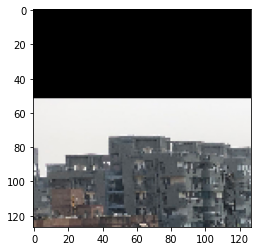

<Figure size 432x288 with 0 Axes>

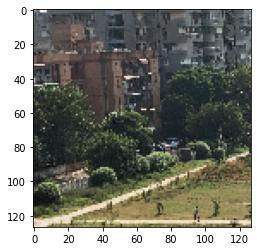

<Figure size 432x288 with 0 Axes>

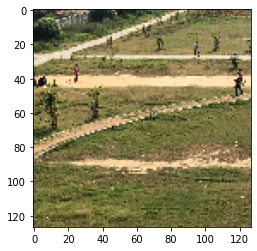

<Figure size 432x288 with 0 Axes>

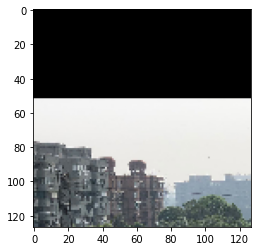

<Figure size 432x288 with 0 Axes>

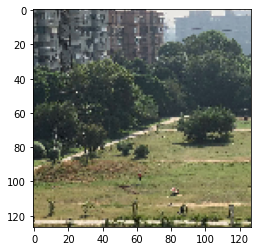

<Figure size 432x288 with 0 Axes>

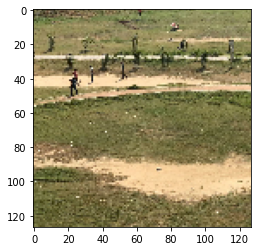

<Figure size 432x288 with 0 Axes>

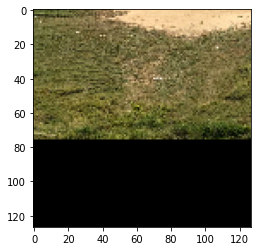

<Figure size 432x288 with 0 Axes>

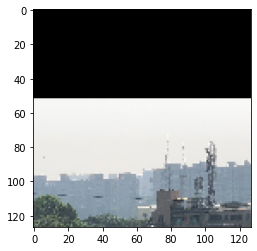

<Figure size 432x288 with 0 Axes>

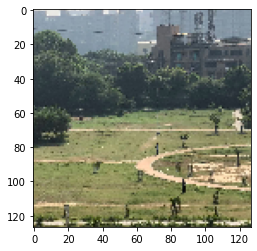

<Figure size 432x288 with 0 Axes>

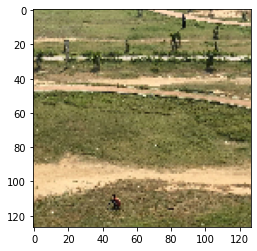

<Figure size 432x288 with 0 Axes>

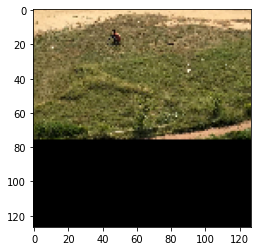

<Figure size 432x288 with 0 Axes>

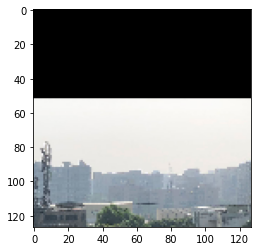

<Figure size 432x288 with 0 Axes>

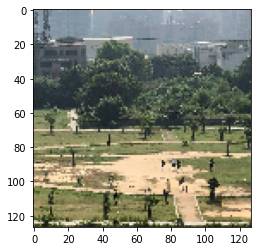

<Figure size 432x288 with 0 Axes>

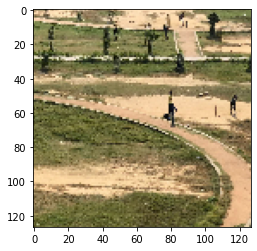

In [12]:
for batch_i, (img_paths, input_imgs) in enumerate(dataloader):
    # Configure input
    #input_imgs = Variable(input_imgs.type(Tensor))

    
    input_imgs = Variable(input_imgs.type(Tensor))
    frame = input_imgs
    det = []

    if (frame.shape[2] > img_size or frame.shape[3]  > img_size) and slidingFlag :
            # Computing frame sliding steps (made so that all cropped frames are 416x416)
        winStepHeight = int((frame.shape[2] - SlidingWinSize) / (int(frame.shape[2] / SlidingWinSize)))
        winStepWidth = int((frame.shape[3] - SlidingWinSize ) / (int(frame.shape[3] / SlidingWinSize)))

        DetectFlag = False
        cropWidth = 0

        while cropWidth + SlidingWinSize <= frame.shape[3] and not DetectFlag:
            cropHeight = 0
            while cropHeight + SlidingWinSize <= frame.shape[2] and not DetectFlag:

                frame_cropped = frame[:, :, cropHeight:cropHeight+SlidingWinSize, cropWidth:cropWidth+SlidingWinSize]
                
                b = frame_cropped.cpu().numpy()[0]
                a = np.moveaxis(b, 0, -1)

                plt.figure()
                fig, ax = plt.subplots(1)
                ax.imshow(a)

                with torch.no_grad():
                    detections = model(frame_cropped)
                    detections = non_max_suppression(detections, opt.conf_thres, opt.nms_thres)

                if detections[0] is not None:
                    det = detections
                    break
                    for i in range(len(detections[0])):
                        detections[0][i][0] += cropHeight
                        detections[0][i][1] += cropHeight
                        detections[0][i][2] += cropWidth
                        detections[0][i][3] += cropWidth
                        i+=1
                  
                    det.extend(detections)
                cropHeight += winStepHeight
            cropWidth += winStepWidth
        detections = torch.cat(det)

                
    
    else:
        print("inside else")
        # Get detections
        with torch.no_grad():
            detections = model(input_imgs)
            detections = non_max_suppression(detections, opt.conf_thres, opt.nms_thres)
            value.append(detections)

    # Get detections
    # with torch.no_grad():
    #     detections = model(input_imgs)
    #     detections = non_max_suppression(detections, opt.conf_thres, opt.nms_thres)
    #     value.append(detections)

    # Log progress
    current_time = time.time()
    inference_time = datetime.timedelta(seconds=current_time - prev_time)
    prev_time = current_time
    #print("\t+ Batch %d, Inference Time: %s" % (batch_i, inference_time))

    # Save image and detections
    imgs.extend(img_paths)
    img_detections.extend(detections)
